Don't be afraid, for I am with you. Don't be discouraged, for I am your God.  
I will strengthen you and help you  
I will hold you up with my victorious right hand.

# Kaggle : New York City Taxi Trip Duration

# 1. Introduction

이번분석에서는 주어진 데이터를 가지고 New York City의 택시 운행시간을 예측하는 프로젝트이다.

좋은 예측 모형은 택시 승객들로 하여금 택시를 이용했을 경우 소비되는 정확한 시간을 제공함으로써 운행시간에 대한 불안감을 줄여줄 수 있을 것이다.

&nbsp;
&nbsp;
<big> Evaluation metrics is RMSE (Root Mean Squared Logarithmic Error)

$$ \epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$



## 1.1 Import Libraries For Analysis

In [2]:
from IPython.display import display
import numpy as np
import pandas as pd
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Map
from ipyleaflet import *
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster     
from geographiclib.geodesic import Geodesic  

# display
from IPython.display import display 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Distance
from math import sin, cos, sqrt, atan2, radians, ceil

# time data
import time, datetime                        
import calendar
import scipy


%matplotlib inline

## 1.2 Load Data Set

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


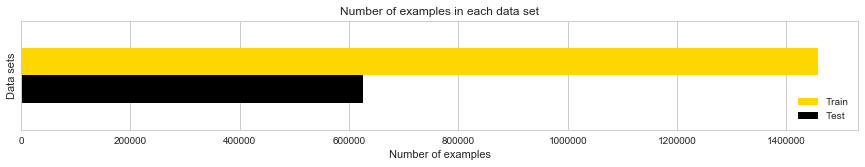

Number of Training Data is 1458644.
Number of Training Data is 625134.


In [4]:
pd.DataFrame({'Train' : [train.shape[0]], 'Test' : [test.shape[0]]}).plot.barh(
figsize=(15, 2), legend='reverse',  color=["black","gold"])
plt.title("Number of examples in each data set")
plt.ylabel("Data sets")
plt.yticks([])
plt.xlabel("Number of examples")
plt.show()

print("Number of Training Data is %i." % train.shape[0])
print("Number of Training Data is %i." % test.shape[0])

In [5]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [6]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


### Columns Explanation

| Feature                    | Explanation                     
|----------------------------|---------------------------------
|id                          | 각 여행마다 부여된 고유 id           
|vendor_id                   | Taxi Company : 2개 회사         
|pickup/dropoff_datetime     | 출발/도착 시간정보 : 년/월/일/시각 포함 
|passenger_count             | 각 여행별 탑승한 승객수 : 0~9명 존재  
|pickup_longitude / latitude | 출발지 지리정보                    
|dropoff_longitude / latitude|  도착지 지리정보                   
|store_and_fwd_flag          | 여행 정보 데이터가 차량 내부에 있는지   
|trip_duration               | 탑승시간                         


## 1.3 Explore Target Data : Trip Duration

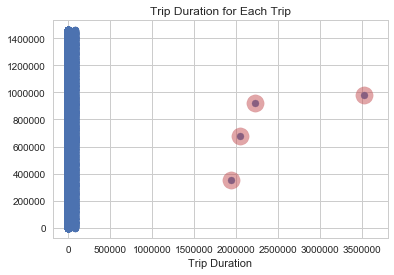

In [9]:
plt.scatter(train.trip_duration, train.index)
plt.xlabel("Trip Duration")
plt.title("Trip Duration for Each Trip")

idx = train.trip_duration > 1500000
plt.scatter(train[idx].trip_duration, train[idx].index, s=300, c="r", alpha=0.5)
    
plt.show()

In [10]:
# Remove Outlier 
train = train.drop(train[idx].index)
len(train)

1439178

In [11]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,3,14,0,17,11,74,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,6,12,6,0,23,164,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,1,19,1,11,3,19,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,4,6,2,19,14,97,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,3,26,5,13,12,86,6.077642


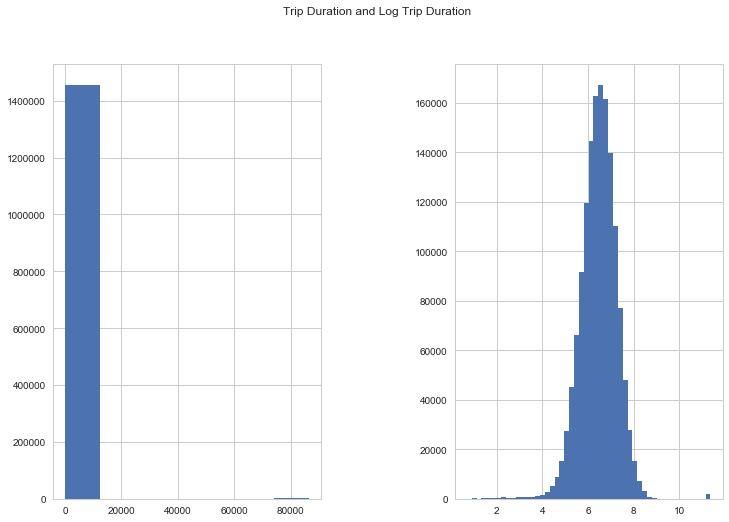

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Trip Duration and Log Trip Duration')

ax1.hist(train.trip_duration, bins=7)
ax2.hist(train.log_trip_duration, bins=50)

plt.show()

In [11]:
print("Log Duration Skewness: %f" % train['log_trip_duration'].skew())
print("Log Duration Kurtosis: %f" % train['log_trip_duration'].kurt())

Log Duration Skewness: -0.293222
Log Duration Kurtosis: 3.832029


In [12]:
len(train[train.trip_duration > 60000])

1957

In [13]:
train = train[train.trip_duration < 60000]

**Observe:**
  * 먼저 4개의 이상값(1달 이상의 Duration)을 발견하여서 제거하였으며,  
    Histogram을 보면 60000초(약 16시간)의 데이터도 1917개정도 보인다.  
    (하루정도 Rent하는 경우도 있을 것 같아서 제거하지 않으려 했으나 우리가 예상을 할때는 Rent에 대한 정보가 주어지지 않으므로 제거하는게 맞아보임)
  * Log Duration을 보면 Negatively skewness를 보이고 있으며, Kurtosis도 3정도로 작은 값들의 영향이 조금 있는 것 같다. 

## 1.4 Visualize Location in New York City Map

### 1.4.1 Distribution of Location Coordinate

In [3]:
# NY City longitude Border = (-74.03, -73.75) NY City latitude Border = (40.63, 40.85)
long_lim = [-74.03, -73.75]
lat_lim = [40.63, 40.85]
train = train[(train.pickup_longitude > long_lim[0]) & (train.pickup_longitude < long_lim[1])]
train = train[(train.dropoff_longitude> long_lim[0]) & (train.dropoff_longitude < long_lim[1])]
train = train[(train.pickup_latitude> lat_lim[0]) & (train.pickup_latitude < lat_lim[1])]
train = train[(train.dropoff_latitude> lat_lim[0]) & (train.dropoff_latitude < lat_lim[1])]

Text(0.5,0,'Dropoff Longitude')

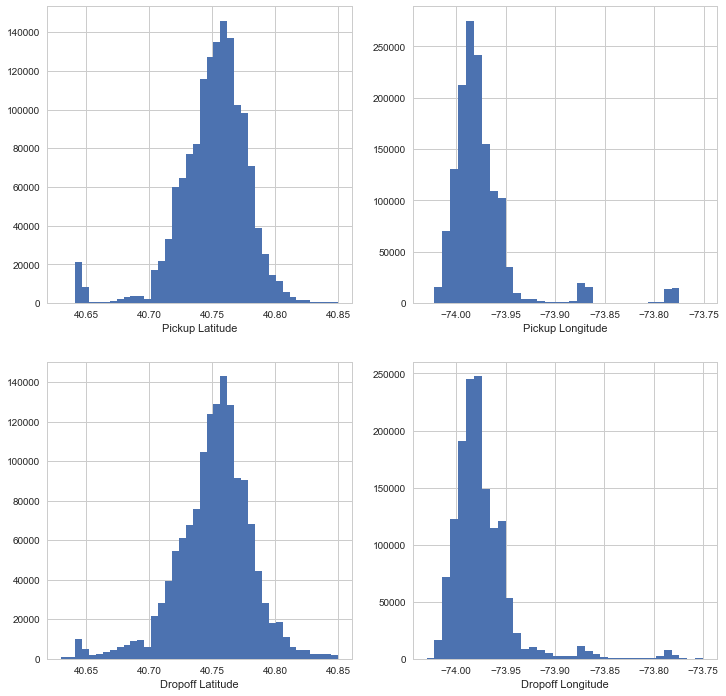

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(12, 12), sharex=False, sharey = False)
ax[0,0].hist(train.pickup_latitude.values, bins=40)
ax[0,1].hist(train.pickup_longitude.values, bins=35)
ax[1,0].hist(train.dropoff_latitude.values, bins=40)
ax[1,1].hist(train.dropoff_longitude.values, bins=35)
ax[0,0].set_xlabel('Pickup Latitude')
ax[0,1].set_xlabel('Pickup Longitude')
ax[1,0].set_xlabel('Dropoff Latitude')
ax[1,1].set_xlabel('Dropoff Longitude')

### 1.4.2 Pickups and Dropoff locations

In [15]:
# pick location and count data on the map

# center location
center=[np.mean(train['pickup_latitude']), np.mean(train['pickup_longitude'])]

map_sample =train.sample(n=2500)

m = folium.Map(
    location = center,
    zoom_start=9)

marker_cluster = MarkerCluster(
    name='2500 clustered icons',
    overlay=True,
    control=False,
    icon_create_function=None
)

for i in range(len(map_sample)):
    location1=[map_sample.iloc[i, 6], map_sample.iloc[i, 5]]
    folium.CircleMarker(
        location=location1,
        radius=1,
        color = "blue"
      ).add_to(m)
#     marker = folium.Marker(location=location1)
#     marker_cluster.add_child(marker)
#     marker_cluster.add_to(m)
    
m

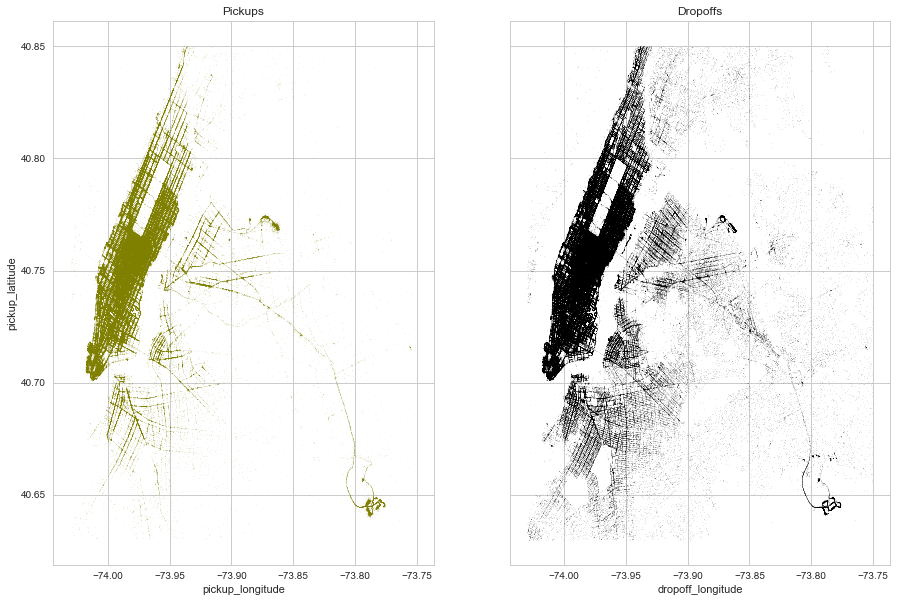

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='olive', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('white')

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='black', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('white') 

**Observe:**
  * 대부분의 여행은 맨하탄 지역에서 발생하였다. (밝게 표시된 지역이 맨하탄 지역)
  * 그 외의 많이 여행한 지역은 두 개의 공항이다. John F. Kennedy and LA Guardia Airport.

# 2. Data

## 2.1 Datetime 다루기

In [4]:
# Pickup/Dropoff_Datetime Datatype 변경

train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [5]:
for df in (train,test):
    # Dates
    df['pickup_date'] = df['pickup_datetime'].dt.date

    #month of year 1 to 12
    df['pickup_month'] = df['pickup_datetime'].dt.month
    
    # day of month 1 to 30/31
    df['pickup_day'] = df['pickup_datetime'].dt.day

    # weekday (Monday=0, Sunday=6)
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday

    #hour of day 0 to 23
    df['pickup_hour'] = df['pickup_datetime'].dt.hour

    #week of year
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear
    
    # day of year
    df['pickup_dayofyear'] = df['pickup_datetime'].dt.dayofyear

In [16]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,2016-03-14,3,14,0,17,11,74
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,2016-06-12,6,12,6,0,23,164
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,2016-01-19,1,19,1,11,3,19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,2016-04-06,4,6,2,19,14,97
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,2016-03-26,3,26,5,13,12,86


### 2.1.1 Month & Trip Duration

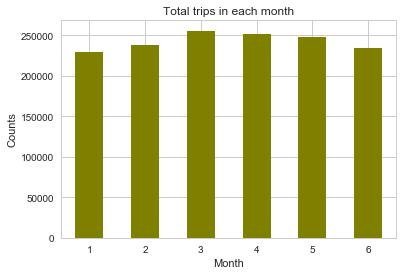

In [17]:
plt.Figure(figsize=(12,8))

train.pickup_month.value_counts().sort_index().plot(kind='bar', color='olive')
plt.xticks(rotation='horizontal')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.title("Total trips in each month")
plt.show()

In [21]:
train_month = pd.DataFrame(train, columns=['vendor_id', 'pickup_month','log_trip_duration'])
train_month = train_month.groupby(['vendor_id', 'pickup_month']).agg('median').reset_index() 

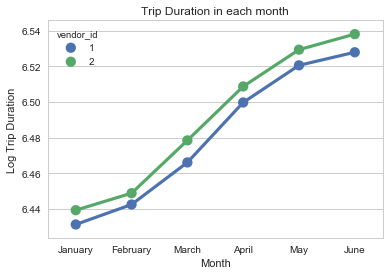

In [22]:
sns.pointplot(x=train_month['pickup_month'], y=train_month['log_trip_duration'], hue = train_month['vendor_id'], data=train_month)
plt.xlabel('Month')
plt.xticks(range(0,6), calendar.month_name[1:7])
plt.ylabel('Log Trip Duration')
plt.title("Trip Duration in each month")
plt.show()

**Observe:**
  * 1월과 6월을 비교했을 때, trip_duration이 1분정도 median이 차이가 난다.  
  * 날씨에 따른 계절적인 요인이 있는 것 같다.
  
> Weather 데이터를 사용해 볼 것을 고려  
> **왜 겨울(1~2월)의 Trip Duration 낮을까?** 상식적으로 높아야 하는데...

### 2.1.2 Trip Duration By DAY

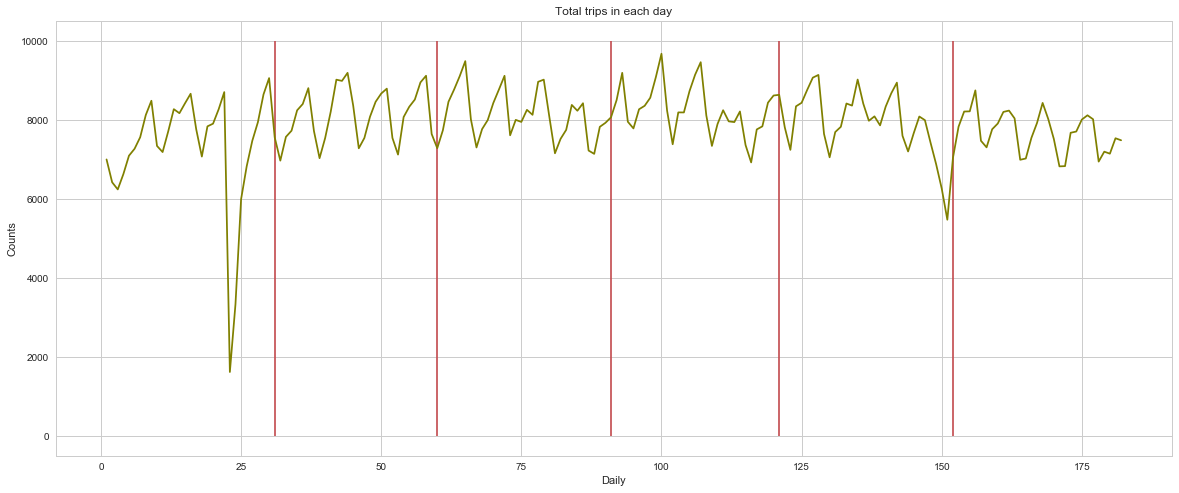

In [23]:
plt.figure(figsize=(20, 8))

train.pickup_dayofyear.value_counts().sort_index().plot(color='olive')
plt.xlabel('Daily')
plt.ylabel('Counts')
plt.title("Total trips in each day")

plt.vlines([31, 31+29, 31+29+31, 31+29+31+30, 31+29+31+30+31], 0, 10000, colors='r', lw=1.7)

plt.show()

In [24]:
print("하루 택시 이용수(평균값) : %i" % train.pickup_dayofyear.value_counts().mean())
print("하루 택시 이용수(중앙값) : %i" %train.pickup_dayofyear.value_counts().median())

하루 택시 이용수(평균값) : 7897
하루 택시 이용수(중앙값) : 7982


In [25]:
train.pickup_dayofyear.value_counts(ascending=True).head(10)

23     1620
24     3333
151    5471
25     5988
3      6238
150    6259
2      6418
4      6625
171    6821
26     6822
Name: pickup_dayofyear, dtype: int64

In [26]:
taxi_day = pd.DataFrame(train, columns=['vendor_id', 'pickup_dayofyear','log_trip_duration'])
taxi_day = taxi_day.groupby(['vendor_id', 'pickup_dayofyear']).agg('median').reset_index() 

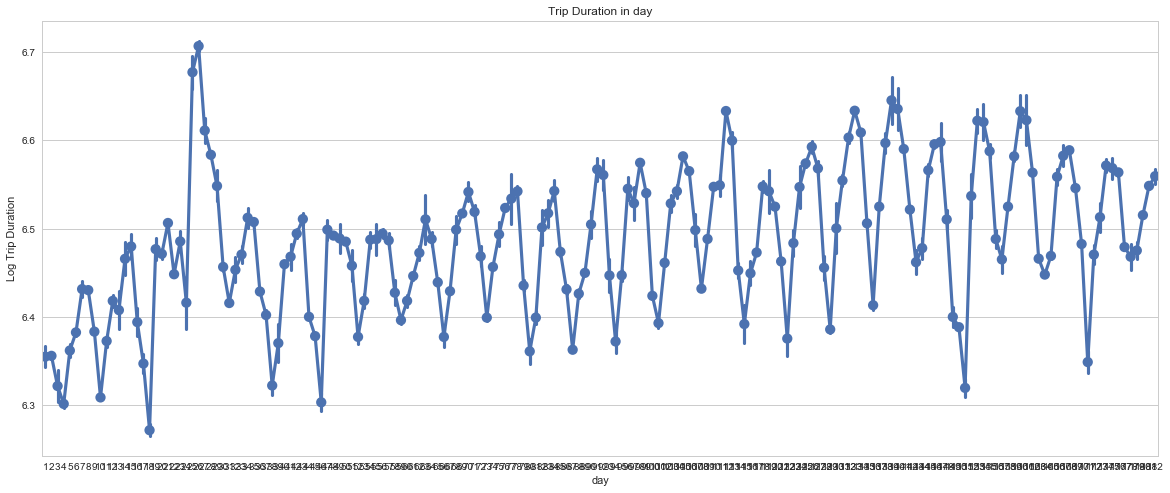

In [27]:
plt.figure(figsize=(20, 8))

sns.pointplot(x=taxi_day['pickup_dayofyear'], y=taxi_day['log_trip_duration'], data=taxi_day)
plt.xlabel('day')
plt.ylabel('Log Trip Duration')
plt.title("Trip Duration in day")
plt.show()

In [28]:
print("일일 Trip Duration(중앙값) : %f" % train.log_trip_duration.median())

일일 Trip Duration(중앙값) : 6.486161


In [29]:
taxi_day[(taxi_day['pickup_dayofyear'] == 23) | (taxi_day['pickup_dayofyear'] == 24) | (taxi_day['pickup_dayofyear'] == 151)]

,vendor_id,pickup_dayofyear,log_trip_duration
22,1,23,6.497529
23,1,24,6.445720
150,1,151,6.329721
204,2,23,6.473891
205,2,24,6.386879
332,2,151,6.309918


**Observe:**
  * 1월 23~24일, 5월 30일에는 하루평균 이용수에 현저하게 낮은 이용빈도를 보이고 있다.
  * 해당 날짜의 Trip Duration도 미세하게 낮은 수준을 보인다.

### 2.1.3 Trip Duration By WEEKDAY

In [30]:
taxi_week = pd.DataFrame(train, columns=['vendor_id', 'pickup_weekday','log_trip_duration'])
taxi_week = taxi_week.groupby(['vendor_id', 'pickup_weekday']).agg('median').reset_index() 

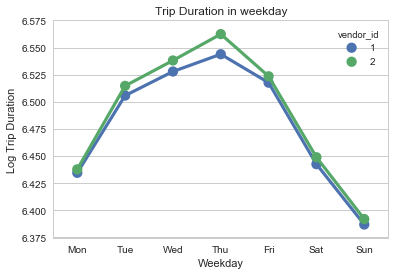

In [31]:
sns.pointplot(x=taxi_week['pickup_weekday'], y=taxi_week['log_trip_duration'], hue = taxi_week['vendor_id'], data=taxi_week)
plt.xlabel('Weekday')
plt.xticks(taxi_week['pickup_weekday'], ('Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
plt.ylabel('Log Trip Duration')
plt.title("Trip Duration in weekday")
plt.show()

**Observe:**
  * 주중 Trip Duration이 높게 나타남
  * 맨하탄 지역이 비지니스 지역이다 보니 업무와 관련이 높은 것 같다.
  
> 주중 중에도 **특이하게 월요일**은 왜 Trip Duration이 낮을까?  
> 주중과 주말을 나누는 카테고리값을 고려

### 2.1.4 Trip Duration By HOUR

In [32]:
taxi_time = pd.DataFrame(train, columns=['vendor_id', 'pickup_hour','log_trip_duration'])
taxi_time = taxi_time.groupby(['vendor_id', 'pickup_hour']).agg('median').reset_index()

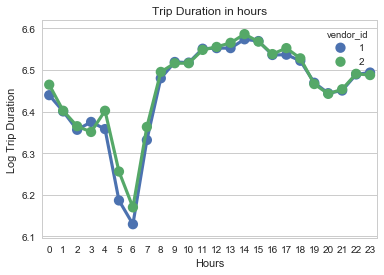

In [33]:
sns.pointplot(x=taxi_time['pickup_hour'], y=taxi_time['log_trip_duration'], hue = taxi_time['vendor_id'], data=taxi_time)
plt.xlabel('Hours')
plt.ylabel('Log Trip Duration')
plt.title("Trip Duration in hours")
plt.show()

**Observe:**
  * 업무시간대인 8~18시까지 Duration이 높게 나왔다.

> 시간에 따른 카테고리값 고려하기 (특히, 업무시간)

**Overall:**
  * 요일과 시간별로 봤을때는 업무시간/업무일과 Trip Duration과의 관계성이 있어 보인다.

> 주말이 아닌 날에 한해서   
  특정 날에 이용횟수가 현격하게 적은 날이 있어서 날씨의 영향인지 확인해야 할 것 같다. (그러나 Trip Duration은 평균값에 큰 차이는 없다.)

## 2.2 Weather

In [18]:
weather = pd.read_csv('weather_data_nyc_centralpark_2016.csv')

# 6월까지만 활용
weather['date'] = pd.to_datetime(weather.date)
weather['dayofyear'] = weather['date'].dt.dayofyear
weather = weather[weather['dayofyear'] < 183]
print(len(weather))
weather.head()

182


,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,dayofyear
0,2016-01-01,42,34,38.0,0.00,0.0,0,1
1,2016-02-01,40,32,36.0,0.00,0.0,0,32
2,2016-03-01,45,35,40.0,0.00,0.0,0,61
3,2016-04-01,36,14,25.0,0.00,0.0,0,92
4,2016-05-01,29,11,20.0,0.00,0.0,0,122


**The temperature** is measured in Fahrenheit and **the depth** is measured in inches.  
**T** means that there is a trace of precipitation.

### 2.2.2 Harsh Weather

In [19]:
weather1 = weather[(weather['snow fall'] > '1') | (weather.precipitation > '1') | (weather['snow depth'] > '20')]
weather1

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,dayofyear
13,2016-01-14,38,22,30.0,0.00,T,0,14
14,2016-01-15,51,34,42.5,T,0.0,0,15
17,2016-01-18,31,18,24.5,T,T,T,18
18,2016-01-19,28,16,22.0,0.00,0.0,T,19
19,2016-01-20,37,27,32.0,0.00,0.0,T,20
22,2016-01-23,27,24,25.5,2.31,27.3,6,23
23,2016-01-24,35,20,27.5,T,T,22,24
26,2016-01-27,47,34,40.5,T,0.0,9,27
27,2016-01-28,42,32,37.0,0.00,0.0,6,28
28,2016-01-29,41,30,35.5,0.00,0.0,6,29


In [20]:
weather1 = weather1[(weather1.precipitation != 'T') & (weather1['snow fall'] != 'T')]
weather1

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,dayofyear
18,2016-01-19,28,16,22.0,0.00,0.0,T,19
19,2016-01-20,37,27,32.0,0.00,0.0,T,20
22,2016-01-23,27,24,25.5,2.31,27.3,6,23
27,2016-01-28,42,32,37.0,0.00,0.0,6,28
28,2016-01-29,41,30,35.5,0.00,0.0,6,29
29,2016-01-30,39,28,33.5,0.00,0.0,6,30
30,2016-01-31,56,36,46.0,0.00,0.0,4,31
32,2016-02-02,50,38,44.0,0.00,0.0,T,33
35,2016-05-02,44,31,37.5,0.53,2.5,1,123
45,2016-02-15,35,13,24.0,0.44,1.4,0,46


In [21]:
weather1 = weather1[(weather1.precipitation != '0.00') | (weather1['snow fall'] != '0.0')]
weather1

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,dayofyear
22,2016-01-23,27,24,25.5,2.31,27.3,6,23
35,2016-05-02,44,31,37.5,0.53,2.5,1,123
45,2016-02-15,35,13,24.0,0.44,1.4,0,46
46,2016-02-16,54,35,44.5,1.01,0.0,0,47
54,2016-02-24,60,36,48.0,1.22,0.0,0,55
63,2016-04-03,39,30,34.5,0.11,0.4,T,94
80,2016-03-21,50,32,41.0,0.06,0.5,T,81
150,2016-05-30,82,68,75.0,1.65,0.0,0,151


In [22]:
weather_list = []
for day in (weather1.dayofyear):
    weather_list.append(day)
weather_list.append(24)
weather_list.remove(94),weather_list.remove(81),weather_list.remove(123),weather_list.remove(46)   
weather_list

[23, 47, 55, 151, 24]

In [23]:
train['harsh_weather'] = train.pickup_dayofyear.isin(weather_list)
test['harsh_weather'] = test.pickup_dayofyear.isin(weather_list)

In [24]:
len(train[train['harsh_weather'] == True])

26661

In [25]:
len(test[test['harsh_weather'] == True])

11480

**Observe:**
  * 25mm이상 비가 내리거나 폭설이 내린날을 다르게 카테고리로 만듬

## 2.3 Categorical Data

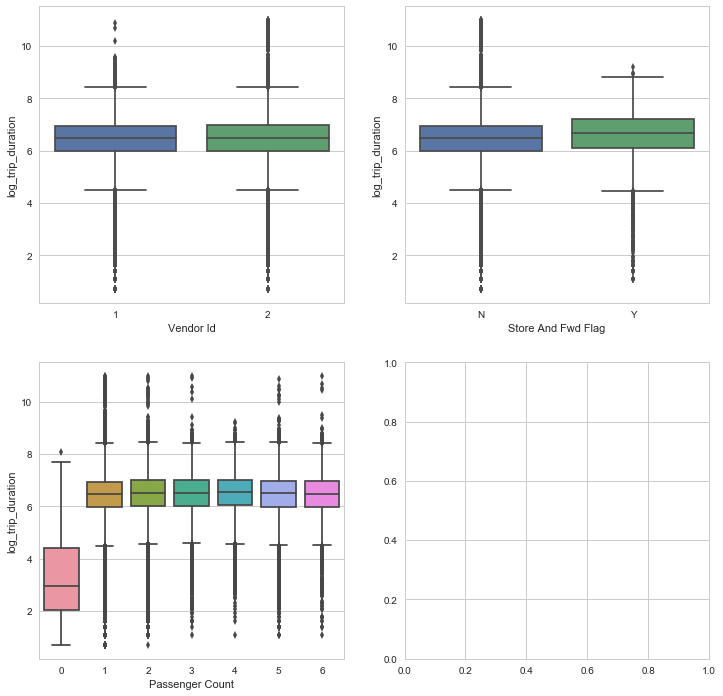

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(12, 12), sharex=False, sharey = False)

sns.boxplot(x="vendor_id", y="log_trip_duration", data=train, ax=ax[0,0])
sns.boxplot(x="store_and_fwd_flag", y="log_trip_duration", data=train, ax=ax[0,1])
sns.boxplot(x="passenger_count", y="log_trip_duration", data=train, ax=ax[1,0])

ax[0,0].set_xlabel('Vendor Id')
ax[0,1].set_xlabel('Store And Fwd Flag')
ax[1,0].set_xlabel('Passenger Count')

plt.show()

In [43]:
print("승객수가 0인 데이터의 수 : %i" % len(train[train.passenger_count == 0]))
train[train.passenger_count == 0]

승객수가 0인 데이터의 수 : 52


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather
136519,id3645383,2,2016-01-01 05:01:32,2016-01-01 05:01:36,0,-73.993134,40.757473,-73.993294,40.757538,N,4,1.609438,2016-01-01,1,1,4,5,53,1,False
194288,id2840829,2,2016-02-21 01:33:52,2016-02-21 01:36:27,0,-73.946243,40.772903,-73.946770,40.774841,N,155,5.049856,2016-02-21,2,21,6,1,7,52,False
217765,id3762593,1,2016-01-04 12:24:17,2016-01-04 13:01:48,0,-73.815224,40.700081,-73.950699,40.755222,N,2251,7.719574,2016-01-04,1,4,0,12,1,4,False
263809,id2154895,1,2016-05-23 23:37:37,2016-05-23 23:37:45,0,-73.861633,40.705029,-73.861633,40.705029,N,8,2.197225,2016-05-23,5,23,0,23,21,144,False
278290,id0796773,1,2016-02-07 17:23:48,2016-02-07 17:23:57,0,-73.954941,40.687866,-73.954742,40.687862,N,9,2.302585,2016-02-07,2,7,6,17,5,38,False
301600,id2091096,2,2016-01-01 23:52:46,2016-01-02 00:27:18,0,-73.993652,40.757046,-73.918869,40.757793,N,2072,7.636752,2016-01-01,1,1,4,23,53,1,False
303133,id0414625,2,2016-01-05 18:52:20,2016-01-05 18:52:35,0,-73.985291,40.738335,-73.985352,40.738361,N,15,2.772589,2016-01-05,1,5,1,18,1,5,False
337809,id0271506,2,2016-05-22 00:23:15,2016-05-22 00:23:56,0,-73.956718,40.777142,-73.956764,40.776958,N,41,3.737670,2016-05-22,5,22,6,0,20,143,False
375972,id3176865,2,2016-05-31 05:10:23,2016-05-31 05:10:38,0,-73.982468,40.727974,-73.982468,40.728001,N,15,2.772589,2016-05-31,5,31,1,5,22,152,False
383407,id3493269,2,2016-01-14 19:09:41,2016-01-14 19:09:48,0,-73.904709,40.758099,-73.904716,40.758148,N,7,2.079442,2016-01-14,1,14,3,19,2,14,False


In [44]:
print("승객수가 0인 데이터의 수 : %i" % len(test[test.passenger_count == 0]))
test[test.passenger_count == 0]

승객수가 0인 데이터의 수 : 23


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather
36479,id0844980,2,2016-06-19 20:43:55,0,-73.875603,40.876747,-73.875549,40.876766,N,2016-06-19,6,19,6,20,24,171,False
61526,id2433902,2,2016-06-12 04:44:29,0,-73.949364,40.775192,-73.949364,40.775219,N,2016-06-12,6,12,6,4,23,164,False
101032,id1685189,1,2016-05-31 20:10:45,0,-73.950829,40.773525,-73.950768,40.773514,N,2016-05-31,5,31,1,20,22,152,False
109879,id3784793,2,2016-05-28 16:17:57,0,-73.975418,40.752178,-74.177490,40.695339,N,2016-05-28,5,28,5,16,21,149,False
150945,id2306909,2,2016-05-16 20:56:42,0,-74.007950,40.709846,-74.008064,40.710007,N,2016-05-16,5,16,0,20,20,137,False
153741,id2305648,1,2016-05-16 00:12:25,0,-73.831436,40.717705,-73.952477,40.770882,N,2016-05-16,5,16,0,0,20,137,False
170119,id2223547,1,2016-05-11 16:48:16,0,-73.983681,40.760532,-74.164627,40.711697,N,2016-05-11,5,11,2,16,19,132,False
207427,id1911563,2,2016-05-01 03:12:02,0,-73.987968,40.765003,-73.987961,40.764996,N,2016-05-01,5,1,6,3,17,122,False
297592,id2251696,1,2016-04-05 21:41:37,0,-73.978188,40.748512,-73.978241,40.748482,N,2016-04-05,4,5,1,21,14,96,False
300704,id0362832,1,2016-04-05 01:28:04,0,-73.565308,41.034004,-73.565308,41.034004,N,2016-04-05,4,5,1,1,14,96,False


**Observe:**
  * Vendor에 따른 Trip Duration의 차이는 크지 않아 보인다.
  * Store & Flag는 중요한 Feature로 생각되지 않는다.
  * Passenger Count는 전반적으로 비슷하나, 승객0인 데이터가 이상함을 보인다.  
    (Test에도 승객이 0인 데이터가 소수 있어서 제거하지 않겠다.)

# 3. Feature Engineer

## 3.1 Distance

In [26]:
# approximate radius of earth in mile

R = 6371.0

dist = []

for i in range(len(train)):
    lat1 = radians(train.iloc[i,6])
    lon1 = radians(train.iloc[i,5])
    lat2 = radians(train.iloc[i,8])
    lon2 = radians(train.iloc[i,7])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    dist.append(distance)
    
train['distance'] = dist
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,2016-03-14,3,14,0,17,11,74,False,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,2016-06-12,6,12,6,0,23,164,False,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,2016-01-19,1,19,1,11,3,19,False,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,2016-04-06,4,6,2,19,14,97,False,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,2016-03-26,3,26,5,13,12,86,False,1.188588


In [27]:
# approximate radius of earth in mile

R = 6371.0

dist = []

for i in range(len(test)):
    lat1 = radians(test.iloc[i,5])
    lon1 = radians(test.iloc[i,4])
    lat2 = radians(test.iloc[i,7])
    lon2 = radians(test.iloc[i,6])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    dist.append(distance)
    
test['distance'] = dist
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2016-06-30,6,30,3,23,26,182,False,2.746426
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2016-06-30,6,30,3,23,26,182,False,2.759239
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,2016-06-30,6,30,3,23,26,182,False,1.306155
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,2016-06-30,6,30,3,23,26,182,False,5.269088
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,2016-06-30,6,30,3,23,26,182,False,0.960842


In [78]:
train.distance.describe()

count    1.437261e+06
mean     3.293699e+00
std      3.664377e+00
min      0.000000e+00
25%      1.224568e+00
50%      2.068222e+00
75%      3.767701e+00
max      2.719163e+01
Name: distance, dtype: float64

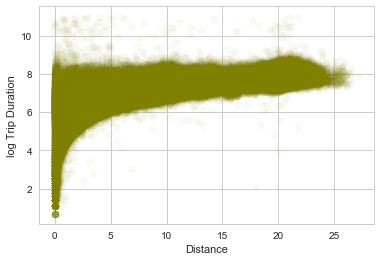

In [79]:
plt.scatter(train.distance, train.log_trip_duration, color="olive", alpha=0.04)
plt.ylabel("log Trip Duration")
plt.xlabel("Distance")
plt.show()

**Observe:**
  * Haversine Formula를 활용해서 출발/도착지의 위도/경도 정보를 통해서 Distance 구함

## 3.2 Number of Steps

In [47]:
fastest_routes1 = pd.read_csv('fastest_routes_train_part_1.csv', usecols=['id', 'number_of_steps'])
fastest_routes2 = pd.read_csv('fastest_routes_train_part_2.csv', usecols=['id', 'number_of_steps'])
train_fastest_routes = pd.concat((fastest_routes1, fastest_routes2))

test_fastest_routes = pd.read_csv('fastest_routes_test.csv', usecols=['id', 'number_of_steps'])

train = train.merge(train_fastest_routes, how='left', on='id')
test = test.merge(test_fastest_routes, how='left', on='id')

In [48]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,3,14,0,17,11,74,False,1.498521,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,6,12,6,0,23,164,False,1.805507,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,1,19,1,11,3,19,False,6.385098,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,4,6,2,19,14,97,False,1.485498,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,3,26,5,13,12,86,False,1.188588,5.0


https://developers.google.com/maps/documentation/directions/intro#Waypoints

**Observe:**
  * Google Map API를 활용해서 교차로 회전 수를 회득

## 3.3 Clustering

In [56]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.neighbors import KNeighborsClassifier

In [50]:
longitude = list(train.pickup_longitude) + list(train.dropoff_longitude)
latitude = list(train.pickup_latitude) + list(train.dropoff_latitude)
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

In [52]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

In [95]:
train['pickup_cluster'] = kmeans.predict(train[['pickup_longitude','pickup_latitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_longitude','dropoff_latitude']])

In [96]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster,pickup_neighborhood,dropoff_neighborhood
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,11,74,False,1.498521,5.0,9,7,Midtown-North-West,Midtown-North-East
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,23,164,False,1.805507,6.0,1,2,Midtown-North-West,Chelsea
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,3,19,False,6.385098,16.0,9,14,Midtown-North-West,Downtown
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,14,97,False,1.485498,4.0,14,14,Downtown,Downtown
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,12,86,False,1.188588,5.0,6,6,Upper West Side,Midtown-North-East


In [70]:
naming = {0: 'Chelsea', 1: 'Queens', 2: 'Morningside height', 3:'Soho', 4: 'East Harlem',
                5:'JFK', 6: 'LaGuardia', 7: 'Uppe East Side', 8:'Midtown',
                9: 'Upper West Side', 10: 'Gramercy', 11: 'Brooklyn-Williamsburgt', 12: 'Brooklyn-Parkside',
                13: 'Queens-Astoria', 14: 'Harlem'}

In [97]:
train['pickup_cluster'] = train['pickup_cluster'].apply(lambda x: '{}'.format(naming[x]))
train['dropoff_cluster'] = train['dropoff_cluster'].apply(lambda x: '{}'.format(naming[x]))

test['pickup_cluster'] = test['pickup_cluster'].apply(lambda x: '{}'.format(naming[x]))
test['dropoff_cluster'] = test['dropoff_cluster'].apply(lambda x: '{}'.format(naming[x]))

In [106]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,14,0,17,11,74,False,1.498521,5.0,Upper West Side,Uppe East Side
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,12,6,0,23,164,False,1.805507,6.0,Queens,Morningside height
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,19,1,11,3,19,False,6.385098,16.0,Upper West Side,Harlem
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,6,2,19,14,97,False,1.485498,4.0,Harlem,Harlem
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,26,5,13,12,86,False,1.188588,5.0,LaGuardia,LaGuardia


In [110]:
# train_cluster = pd.DataFrame(titanic, columns=["pickup_cluster", "dropoff_cluster"])
train_cluster = train.groupby(["pickup_cluster","dropoff_cluster"]).size().reset_index(name='Counts')
train_cluster.tail()


,pickup_cluster,dropoff_cluster,Counts
220,Upper West Side,Queens,29279
221,Upper West Side,Queens-Astoria,1663
222,Upper West Side,Soho,2225
223,Upper West Side,Uppe East Side,31357
224,Upper West Side,Upper West Side,44818


In [113]:
pivot1 = train_cluster.pivot("pickup_cluster", "dropoff_cluster", "Counts")

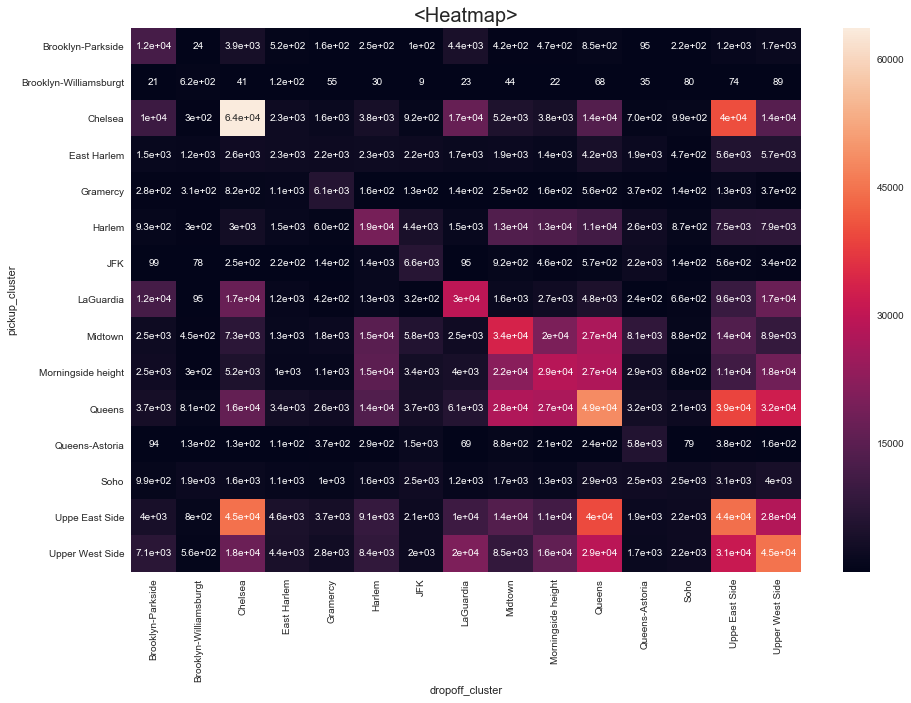

In [114]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pivot1, annot=True)
plt.title("<Heatmap>", fontsize = 20)

plt.show()

In [117]:
train_cluster1 = train.groupby(["pickup_cluster","dropoff_cluster"]).mean()['log_trip_duration'].reset_index()
train_cluster1.tail()

,pickup_cluster,dropoff_cluster,log_trip_duration
220,Upper West Side,Queens,6.406437
221,Upper West Side,Queens-Astoria,7.532787
222,Upper West Side,Soho,7.968793
223,Upper West Side,Uppe East Side,6.335433
224,Upper West Side,Upper West Side,5.843023


In [127]:
train_cluster1.pivot_table(index=["pickup_cluster","dropoff_cluster"])

log_trip_duration
pickup_cluster         dropoff_cluster                          
Brooklyn-Parkside      Brooklyn-Parkside                5.852195
                       Brooklyn-Williamsburgt           7.546082
                       Chelsea                          6.322834
                       East Harlem                      7.049279
                       Gramercy                         7.102992
                       Harlem                           7.428905
                       JFK                              7.680324
                       LaGuardia                        6.167289
                       Midtown                          7.311259
                       Morningside height               7.271459
                       Queens                           7.253389
                       Queens-Astoria                   7.699091
                       Soho                             7.764152
                       Uppe East Side                   7.085446
                       Upper West Side                  6.940163
Brooklyn-Williamsburgt Brooklyn-Parkside                7.514501
                       Brooklyn-Williamsburgt           5.733860
                       Chelsea                          7.306719
                       East Harlem                      6.524510
                       Gramercy                         6.894551
                       Harlem                           7.631452
                       JFK                              7.628679
                       LaGuardia                        7.880099
                       Midtown                          7.424748
                       Morningside height               7.628090
                       Queens                           7.281477
                       Queens-Astoria                   7.127279
                       Soho                             6.570399
                       Uppe East Side                   7.399218
                       Upper West Side                  7.734629
...                                                          ...
Uppe East Side         Brooklyn-Parkside                6.920119
                       Brooklyn-Williamsburgt           7.428392
                       Chelsea                          6.130568
                       East Harlem                      7.317489
                       Gramercy                         6.787049
                       Harlem                           7.124328
                       JFK                              7.450367
                       LaGuardia                        6.686087
                       Midtown                          6.729310
                       Morningside height               6.906079
                       Queens                           6.364578
                       Queens-Astoria                   7.247495
                       Soho                             7.825588
                       Uppe East Side                   5.849884
                       Upper West Side                  6.448724
Upper West Side        Brooklyn-Parkside                6.918827
                       Brooklyn-Williamsburgt           7.620342
                       Chelsea                          6.701570
                       East Harlem                      7.540367
                       Gramercy                         7.108947
                       Harlem                           7.167829
                       JFK                              7.571574
                       LaGuardia                        6.194175
                       Midtown                          7.061604
                       Morningside height               6.475471
                       Queens                           6.406437
                       Queens-Astoria                   7.532787
                       Soho                             7.968793
                       Uppe East Side                   6.335433
                 

**Observe:**
  * 같은 위치(클러스터) 안에서의 Trip이 많다.
  * 뉴욕의 행정구역이 5개인데 
    그 중에서 Manhattan 지역 안에서의 Trip의 횟수가 많다.
  * 출발지와 도착지에 따라 당연히 Trip Duration이 다르게 나타난다.

## 3.4 Speed

### 3.4.1 Average Speed

In [137]:
train.loc[:, 'speed(km/h)'] = train['distance'] / (train['trip_duration'] / 3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster,avg_speed_h,speed(km/h)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,11,74,False,1.498521,5.0,Upper West Side,Uppe East Side,11.856428,11.856428
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,23,164,False,1.805507,6.0,Queens,Morningside height,9.803659,9.803659
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,3,19,False,6.385098,16.0,Upper West Side,Harlem,10.822201,10.822201
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,14,97,False,1.485498,4.0,Harlem,Harlem,12.465721,12.465721
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,12,86,False,1.188588,5.0,LaGuardia,LaGuardia,9.836594,9.836594


In [138]:
train_cluster2 = train.groupby(["pickup_cluster","dropoff_cluster"]).mean()['speed(km/h)'].reset_index()
train_cluster2.tail()

,pickup_cluster,dropoff_cluster,speed(km/h)
220,Upper West Side,Queens,10.591036
221,Upper West Side,Queens-Astoria,14.615092
222,Upper West Side,Soho,27.840384
223,Upper West Side,Uppe East Side,9.745591
224,Upper West Side,Upper West Side,10.708877


In [146]:
avg_speed = train_cluster2.pivot_table(index=["pickup_cluster","dropoff_cluster"])
avg_speed.head()

speed(km/h)
pickup_cluster    dropoff_cluster                    
Brooklyn-Parkside Brooklyn-Parkside         13.667238
                  Brooklyn-Williamsburgt    31.393414
                  Chelsea                   16.757572
                  East Harlem               24.743053
                  Gramercy                  19.094401

### 3.4.2 Average Speed for regions

In [170]:
train.loc[1, 'pickup_cluster']

'Queens'

In [144]:
avg_speed.index[0][1]

'Brooklyn-Parkside'

In [180]:
avg_speed.loc[('Upper West Side', 'Uppe East Side'), 'speed(km/h)']

9.745590946025391

In [184]:
for i in range(len(train)):
    train.loc[i, 'avg_speed_h'] = avg_speed.loc[(train.loc[i, 'pickup_cluster'], train.loc[i, 'dropoff_cluster']), 'speed(km/h)']

In [185]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster,avg_speed_h,speed(km/h)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,11,74,False,1.498521,5.0,Upper West Side,Uppe East Side,9.745591,11.856428
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,23,164,False,1.805507,6.0,Queens,Morningside height,12.542891,9.803659
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,3,19,False,6.385098,16.0,Upper West Side,Harlem,16.602190,10.822201
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,14,97,False,1.485498,4.0,Harlem,Harlem,9.951657,12.465721
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,12,86,False,1.188588,5.0,LaGuardia,LaGuardia,15.176490,9.836594


In [186]:
for i in range(len(test)):
    test.loc[i, 'avg_speed_h'] = avg_speed.loc[(test.loc[i, 'pickup_cluster'], test.loc[i, 'dropoff_cluster']), 'speed(km/h)']

**Observe:**
  * Train 데이터를 활용하여 출발지와 도착지에 따른 평균속도를 구함
  * 뉴욕의 행정구역이 5개인데 
    그 중에서 Manhattan 지역 안에서의 Trip의 횟수가 많다.

## 3.5 Direction

In [198]:
def calculate_bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * 
         np.sin(dropoff_lat_rads) - 
         np.sin(pickup_lat_rads) * 
         np.cos(dropoff_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [199]:
train['bearing'] = calculate_bearing(train.pickup_latitude,
                                     train.pickup_longitude,
                                     train.dropoff_latitude,
                                     train.dropoff_longitude)

In [200]:
test['bearing'] = calculate_bearing(test.pickup_latitude,
                                     test.pickup_longitude,
                                     test.dropoff_latitude,
                                     test.dropoff_longitude)

## 3.6 Work Time

In [80]:
bins = [0, 8, 18, 24]
group_names = ["before_work", "work", "after_work"]
train['work_hour'] = pd.cut(train['pickup_hour'], bins, labels=group_names, right=False)

test['work_hour'] = pd.cut(test['pickup_hour'], bins, labels=group_names, right=False)

In [203]:
display(train.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster,avg_speed_h,speed(km/h),work_hour,bearing
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,2016-03-14,3,14,0,17,11,74,False,1.498521,5.0,Upper West Side,Uppe East Side,9.745591,11.856428,work,174.333195
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,2016-06-12,6,12,6,0,23,164,False,1.805507,6.0,Queens,Morningside height,12.542891,9.803659,before work,-178.051506
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,2016-01-19,1,19,1,11,3,19,False,6.385098,16.0,Upper West Side,Harlem,16.602190,10.822201,work,-179.629721
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,2016-04-06,4,6,2,19,14,97,False,1.485498,4.0,Harlem,Harlem,9.951657,12.465721,after work,-179.872566
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,2016-03-26,3,26,5,13,12,86,False,1.188588,5.0,LaGuardia,LaGuardia,15.176490,9.836594,work,179.990812


In [188]:
train.to_csv("train_new.csv", index=False)
test.to_csv("test_new.csv", index=False)